### Problem Description: Histopathologic Cancer Detection
The Histopathologic Cancer Detection challenge on Kaggle involves building a binary classifier to detect metastatic cancer in histopathologic tissue images. The dataset consists of histology image patches, each labeled as either 1 (tumor) or 0 (normal). The training set contains approximately 220025 labeled images, while the test set includes 57458 unlabeled samples. Images are stored in a flat folder structure and must be loaded using custom datasets.

[github repo](https://github.com/Bilal1k/CancerCNN/tree/main)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from skimage.io import imread
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score
from tqdm import tqdm_notebook as tqdm
from torchmetrics.classification import BinaryAUROC


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
path='./data/train/'
annotation_file='./data/train_labels.csv'
test_path='./data/test/'
firstTrainImage = os.listdir(path)[0].split('.')[0]
print(firstTrainImage)

00001b2b5609af42ab0ab276dd4cd41c3e7745b5


In [3]:
train_data =pd.read_csv('./data/train_labels.csv')
sub = pd.read_csv('./data/sample_submission.csv')
train_data[train_data['id'] == firstTrainImage]

id  label
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1

### Data Quality Check

No duplicates: True
Number of unlabeled training images: 32


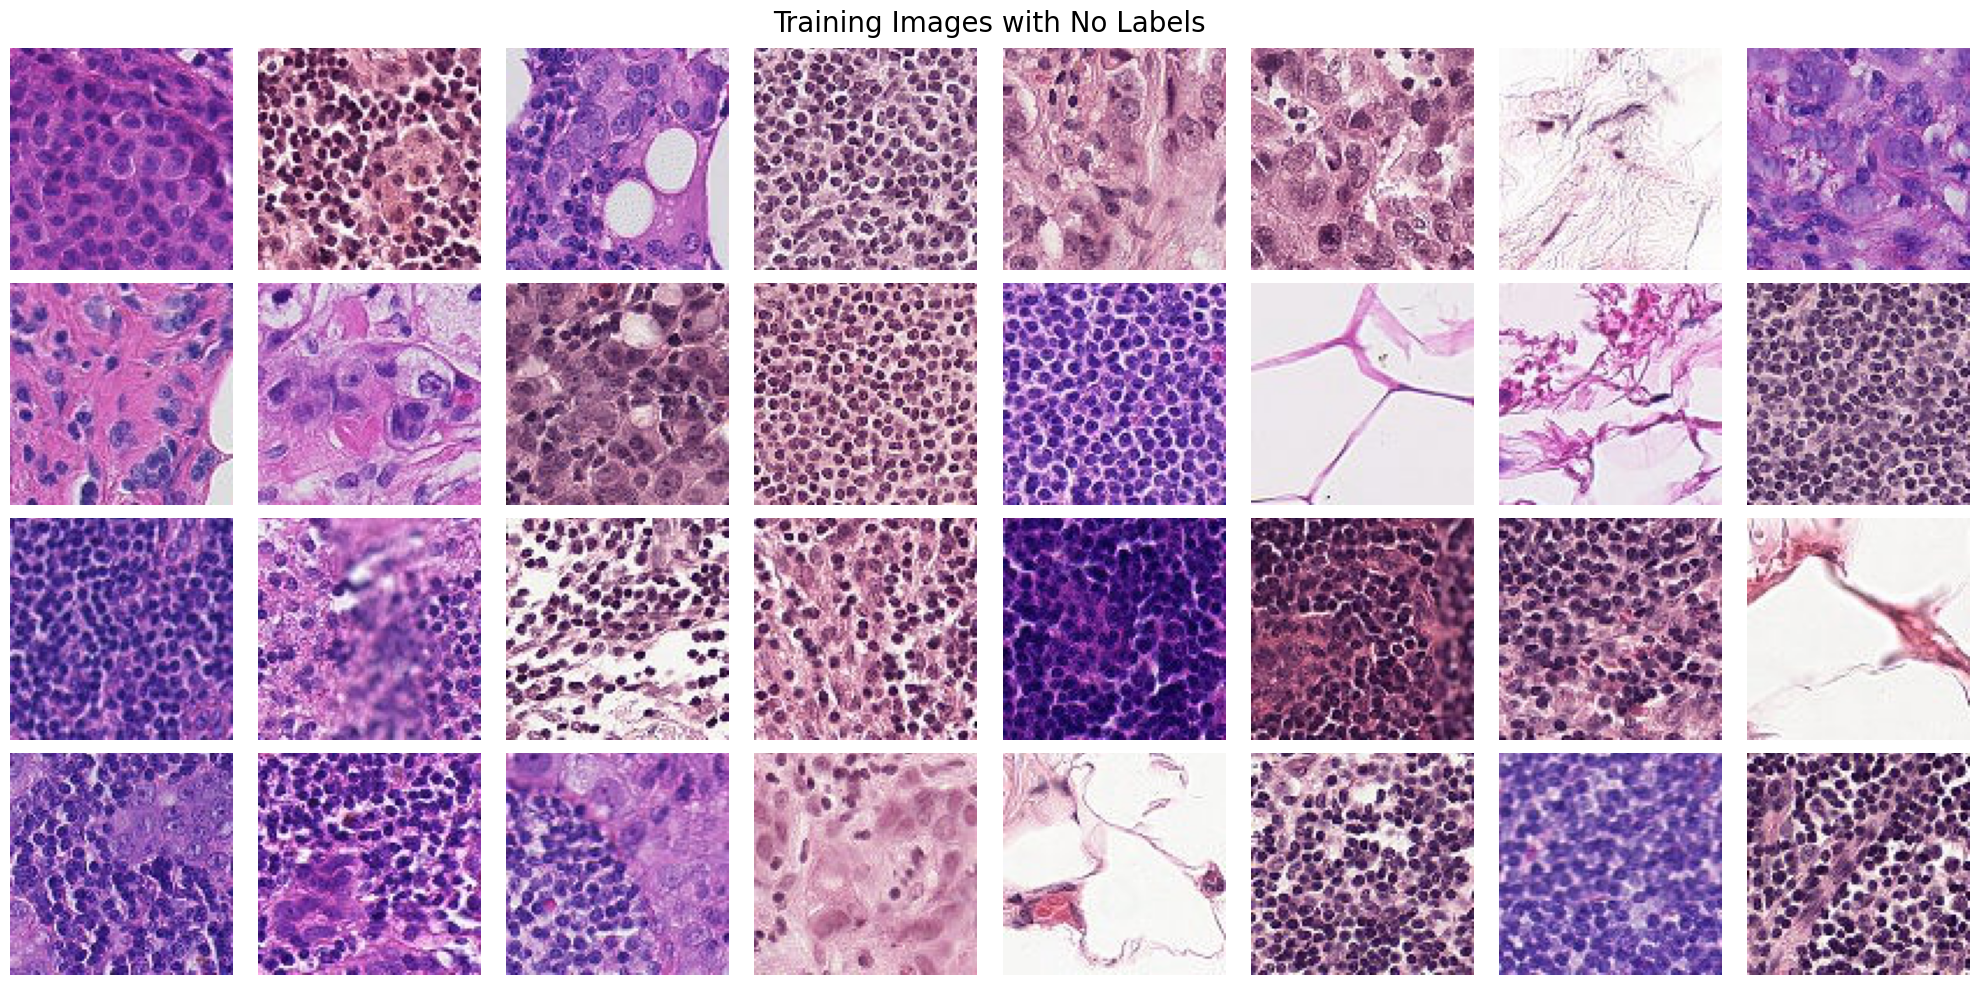

In [ ]:
# Find duplicates 
print(f"No duplicates: {len(train_data['id'].unique()) == len(train_data['id'])}")

# Count unlabeled training images
all_image_ids = {f.split(".")[0] for f in os.listdir(path)}
labeled_image_ids = set(train_data["id"].values)
unlabeled_ids = list(all_image_ids - labeled_image_ids)
print(f"Number of unlabeled training images: {len(unlabeled_ids)}")

# Prepare subplot (4 rows × 8 cols = 32 images)
fig, ax = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle("Training Images with No Labels", fontsize=20)
ax = ax.flatten()

for i, img_id in enumerate(unlabeled_ids[:32]):
    image_path = os.path.join(path, img_id + ".tif")
    image = plt.imread(image_path)
    ax[i].imshow(image)
    ax[i].axis("off")

plt.tight_layout()
plt.show()

Nothing looks special about these images. Workflow will just ignore them as only images listed in train_labels.csv will be picked up.

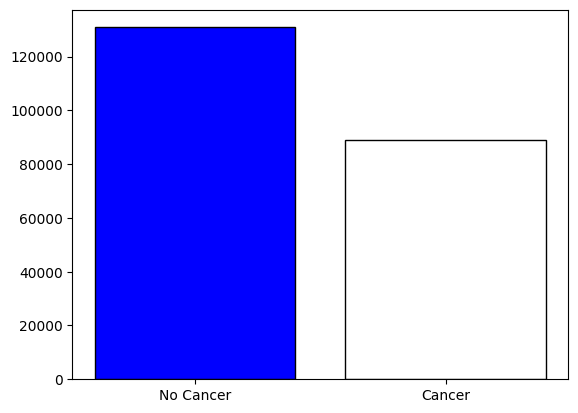

220025

In [4]:
# Check how balanced are the label
plt.bar(['No Cancer', 'Cancer'], train_data.label.value_counts().values, color=['blue', 'white'], edgecolor='black')
plt.show()
len(train_data)

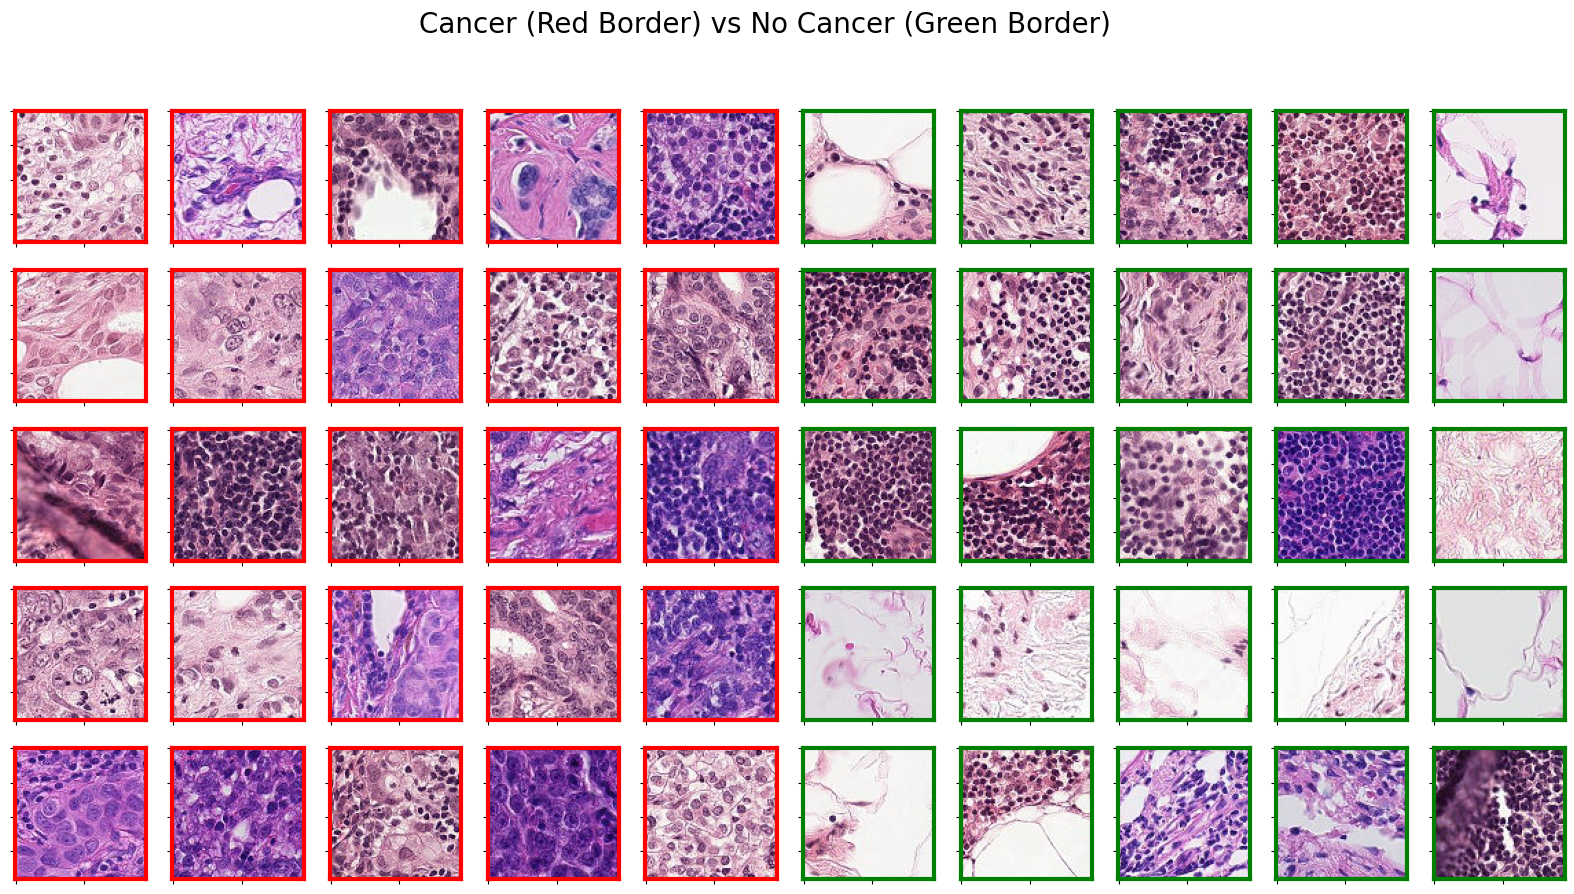

In [7]:
# Compare samples cancer images to non cancer ones
cancer = np.random.choice(train_data[train_data.label==1].id, size=25, replace=False)
no_cancer = np.random.choice(train_data[train_data.label==0].id, size=25, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))
fig.suptitle("Cancer (Red Border) vs No Cancer (Green Border)", fontsize=20)

for i in range(5):
    for j in range(10):
        idx = i * 5 + (j % 5)
        img_id = cancer[idx] if j < 5 else no_cancer[idx]
        image = plt.imread(path + img_id + ".tif")

        ax[i, j].imshow(image)
        ax[i, j].tick_params(labelbottom=False, labelleft=False)
        for spine in ax[i, j].spines.values():
            spine.set_edgecolor('red' if j < 5 else 'green')
            spine.set_linewidth(3)


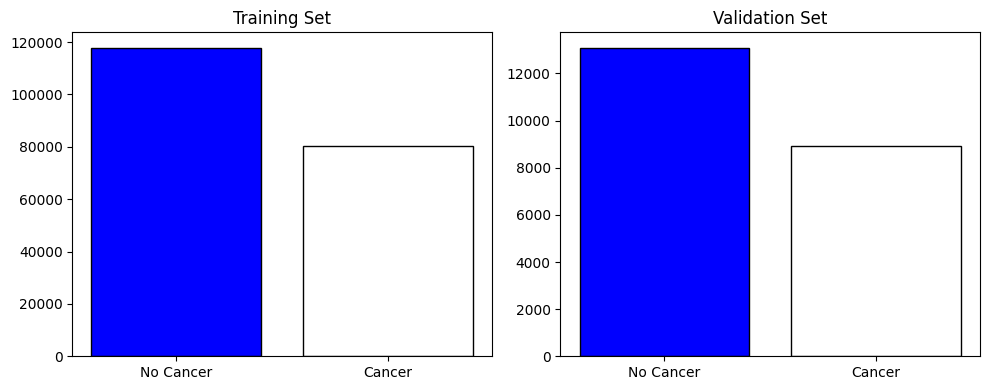

In [6]:
train_df, val_df = train_test_split(train_data, test_size=0.1, stratify=train_data['label'], random_state=42)

# 2. Plot class distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Training set
train_counts = train_df['label'].value_counts().sort_index()
ax[0].bar(['No Cancer', 'Cancer'], train_counts, color=['blue', 'white'], edgecolor='black')
ax[0].set_title('Training Set')

# Validation set
val_counts = val_df['label'].value_counts().sort_index()
ax[1].bar(['No Cancer', 'Cancer'], val_counts, color=['blue', 'white'], edgecolor='black')
ax[1].set_title('Validation Set')

plt.tight_layout()

In [ ]:
class CancerDataset(Dataset):
    """
    Custom PyTorch Dataset for loading cancer image data. To be used with DataLoader()
    
    Each sample consists of an image loaded from disk and its associated label.
    """
    
    def __init__(self, dataframe, image_dir='./', transform=None):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame with columns [image_id, label].
            image_dir (str): Directory where image files are stored.
            transform (callable, optional): Optional transform to apply to each image.
        """
        self.image_labels = dataframe.values         # Convert to NumPy array for indexing
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        """Return total number of samples."""
        return len(self.image_labels)

    def __getitem__(self, index):
        """Load and return a single (image, label) pair."""
        image_id, label = self.image_labels[index]
        image_path = os.path.join(self.image_dir, f"{image_id}.tif")
        
        image = imread(image_path)  # Load image from disk
        
        if self.transform:
            image = self.transform(image)

        return image, label

### Model Architecture and Justification
The BasicCNN model is a lightweight convolutional neural network designed for binary image classification of histopathologic images. The architecture follows a modular design consisting of:

-   Three convolutional blocks, each composed of:

    -   A Conv2d layer with increasing channels (e.g., 16 to 32 to 64)

    -   A ReLU activation for non-linearity

    -   A downsampling operation via MaxPool2d

-   An adaptive average pooling layer to reduce the final feature map to a 1×1 spatial size regardless of input dimensions

-   A classifier head, consisting of:

    -   A Flatten layer

    -   A Dropout layer to mitigate overfitting

    -   A fully connected Linear layer with a single output (one logit) for binary classification

The architecture is controlled by 3 tunable hyperparameters:

-   base_channels: controls the number of filters in the first conv layer (e.g., 16), which then scale up in deeper layers

-   dropout: controls regularization strength in the classifier (e.g., 0.4)

-   learning rate: controls the learning rate of the scaler (e.g., 0.01)


This model structure is well-suited to the Histopathologic Cancer Detection task for several reasons:

-   Small input images do not require deep or heavy architectures; three convolutional layers are sufficient to capture both texture and structural patterns.

-   MaxPooling and channel expansion allow the network to progressively learn more abstract features while reducing spatial resolution, balancing efficiency and expressiveness.

-   Adaptive pooling removes the need to hard-code output sizes and ensures flexibility if image resolution changes.

-   Dropout and batch normalization help regularize the network and stabilize training, which is particularly helpful when using small training subsets for experimentation.

-   Most importantly, the model is small and fast: it can train in minutes on Kaggle’s free GPU while still "hopefully" reaching competitive AUC scores.

This architecture is intentionally compact to optimize learning speed and memory usage, ideal for a learning project with computational constraints, where frequent iteration is more important than state-of-the-art results.

In [8]:
class BasicCNN(nn.Module):
    def __init__(self, base_channels=8, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(base_channels*4, 1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.classifier(x)

In [ ]:
# Helper functions
def train_one_epoch(model, dataloader, device, criterion, optimizer):
    model.train()
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, dataloader, device):
    model.eval()
    metric = BinaryAUROC().to(device)
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            metric.update(probs, labels)
    return metric.compute().item()

# function to get sample of the data for model selection and hyperparam tuning
def get_sample_loader(df, image_dir, fraction=0.1, batch_size=32, transform=None):
    df_small, _ = train_test_split(df, test_size=1-fraction, stratify=df['label'], random_state=42)
    ds = CancerDataset(df_small, image_dir, transform=transform)
    return DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)

### Tune Hyperparameter

For normalization, we are using 0.5 as the midpoint. Calculating the real mean and std can take a very long time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL image (required torchvision transforms)    
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor and scale pixel values to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  
                         std=[0.5, 0.5, 0.5])    # Normalize using midpoints. It takes too long to get the real mean and std 
])

# Create data subset
train_loader = get_sample_loader(train_data, path, fraction=0.1, transform=transform)
val_loader   = get_sample_loader(train_data, path, fraction=0.05, transform=transform)

# List of configs to try
configs = [
    {"channels": 4,  "dropout": 0.3, "lr": 1e-2},
    {"channels": 8, "dropout": 0.25, "lr": 1e-3},
    {"channels": 16,  "dropout": 0.2, "lr": 1e-4},
]

results = []

for cfg in configs:
    print(f"Testing config: {cfg}")
    model = BasicCNN(base_channels=cfg["channels"], dropout=cfg["dropout"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
    criterion = nn.BCEWithLogitsLoss()

    train_one_epoch(model, train_loader, device, criterion, optimizer)
    val_auc = evaluate(model, val_loader, device)

    results.append((cfg, val_auc))
    print(f"AUC: {val_auc:.4f}\n")


Testing config: {'channels': 4, 'dropout': 0.3, 'lr': 0.01}
AUC: 0.8598

Testing config: {'channels': 8, 'dropout': 0.25, 'lr': 0.001}
AUC: 0.8533

Testing config: {'channels': 16, 'dropout': 0.2, 'lr': 0.0001}
AUC: 0.8367



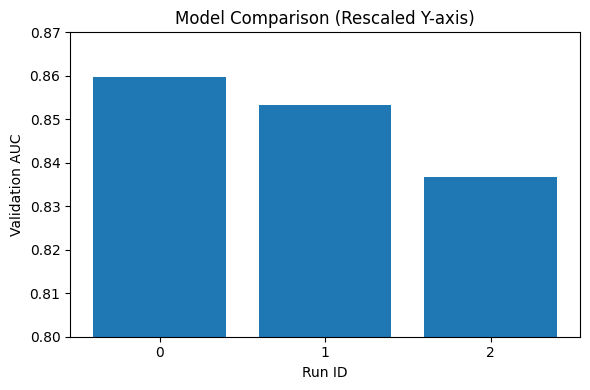

In [11]:
records = []
for cfg, auc in results:
    row = cfg.copy()
    row["val_auc"] = auc
    records.append(row)

df = pd.DataFrame.from_records(records)
df.index.name = "run_id"


# Bar chart 
plt.figure(figsize=(6, 4))
plt.bar(df.index.astype(str), df["val_auc"])
plt.xlabel("Run ID")
plt.ylabel("Validation AUC")
plt.title("Model Comparison (Rescaled Y-axis)")
plt.ylim(0.80, 0.87)  # Tight Y-axis to amplify visual differences
plt.tight_layout()
plt.show()


In [12]:
best_cfg = max(results, key=lambda x: x[1])
print(f"Best config: {best_cfg[0]}, AUC: {best_cfg[1]:.4f}")

Best config: {'channels': 4, 'dropout': 0.3, 'lr': 0.01}, AUC: 0.8598


The best-performing hyperparameter combination was {channels: 4, dropout: 0.3, lr: 0.01}, achieving a validation AUC of 0.8598. One possible explanation is that the lower number of channels (i.e., a smaller model) helped prevent overfitting on the small training subset. The relatively high learning rate (0.01) may have accelerated convergence allowing the model to find a good local optimum quickly, especially since we are using only one epoch. The moderate dropout (0.3) likely provided just enough regularization to balance underfitting and overfitting.

That said, it’s important to note that there is a degree of randomness in training due to weight initialization, data shuffling, and GPU behavior. More importantly, this tuning was performed on only 10% of the dataset, so the results are sensitive to sample selection. Rerunning the same test with a different random subset or seed could yield different “best” hyperparameters, and additional tuning or cross-validation would be required for more stable conclusions.

In [13]:
train_dataset = CancerDataset(dataframe=train_df, image_dir=path, transform=transform)
val_dataset = CancerDataset(dataframe=val_df, image_dir=path, transform=transform)
test_dataset = CancerDataset(dataframe=sub, image_dir=test_path, transform=transform)

In [ ]:
# Hyperparameter and model settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size= 256
shuffle=False
num_workers= os.cpu_count()
pin_memory=True
persistent_workers=True
learning_rate = best_cfg[0]['lr']
dropout = best_cfg[0]['dropout']
channels = best_cfg[0]['channels']

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,            
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,            
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,            
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

In [ ]:
model = BasicCNN(base_channels=channels, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")
print(model)

BasicCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): AdaptiveAvgPool2d(output_size=1)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


### Training Loop

In [16]:
NUM_EPOCHS = 20
is_cuda = device.type == "cuda"                 
best_val_auc = 0.0
BEST_MODEL_PATH = "best_model.pt"

#  Metric history containers
train_loss_hist = []
val_loss_hist   = []
train_auc_hist  = []
val_auc_hist    = []

# Define AUC metrics and move them to the correct device
train_auc_metric = BinaryAUROC().to(device)
val_auc_metric   = BinaryAUROC().to(device)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    train_auc_metric.reset()
    running_train_loss = 0.0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")):

        # Move data to GPU / CPU
        images = images.to(device, non_blocking=True)
        labels = labels.float().unsqueeze(1).to(device, non_blocking=True)

        optimizer.zero_grad()

        #  forward / backward (mixed precision if CUDA) 
        with torch.cuda.amp.autocast(enabled=is_cuda):
            outputs = model(images)
            loss    = criterion(outputs, labels)

        if scaler.is_enabled():       
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:                          # CPU fallback
            loss.backward()
            optimizer.step()


        running_train_loss += loss.item()
        train_auc_metric.update(outputs, labels)

    # Epoch-level metrics
    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_auc  = train_auc_metric.compute().item()


    # Validation
    model.eval()
    val_auc_metric.reset()
    running_val_loss = 0.0

    with torch.no_grad():
        
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader, total=len(val_loader))):

            images = images.to(device, non_blocking=True)
            labels = labels.float().unsqueeze(1).to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=is_cuda):
                outputs = model(images)
                loss    = criterion(outputs, labels)

            running_val_loss += loss.item()
            val_auc_metric.update(outputs, labels)

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_auc  = val_auc_metric.compute().item()
    
    # Save best model (based on validation AUC)
    if avg_val_auc > best_val_auc:
        best_val_auc = avg_val_auc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"Saved new best model at epoch {epoch+1} (Val AUC: {avg_val_auc:.4f})")
    
    # Append to history lists
    train_loss_hist.append(avg_train_loss)
    val_loss_hist.append(avg_val_loss)
    train_auc_hist.append(avg_train_auc)
    val_auc_hist.append(avg_val_auc)    
    
    # Epoch summary
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Train AUC : {avg_train_auc :.4f} | Val AUC : {avg_val_auc :.4f}")
    print("-" * 60)

    # Reset resume pointer for the next epoch
    start_batch = -1


100%|██████████| 86/86 [00:49<00:00,  1.73it/s]


Saved new best model at epoch 1 (Val AUC: 0.8903)
Epoch 1/20
Train Loss: 0.4881 | Val Loss: 0.4186
Train AUC : 0.8428 | Val AUC : 0.8903
------------------------------------------------------------


100%|██████████| 86/86 [00:15<00:00,  5.52it/s]


Saved new best model at epoch 2 (Val AUC: 0.9061)
Epoch 2/20
Train Loss: 0.4294 | Val Loss: 0.3858
Train AUC : 0.8799 | Val AUC : 0.9061
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.83it/s]


Saved new best model at epoch 3 (Val AUC: 0.9071)
Epoch 3/20
Train Loss: 0.4128 | Val Loss: 0.3822
Train AUC : 0.8888 | Val AUC : 0.9071
------------------------------------------------------------


100%|██████████| 86/86 [00:15<00:00,  5.73it/s]


Saved new best model at epoch 4 (Val AUC: 0.9152)
Epoch 4/20
Train Loss: 0.4037 | Val Loss: 0.3685
Train AUC : 0.8936 | Val AUC : 0.9152
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.81it/s]


Epoch 5/20
Train Loss: 0.4001 | Val Loss: 0.3754
Train AUC : 0.8956 | Val AUC : 0.9090
------------------------------------------------------------


100%|██████████| 86/86 [00:16<00:00,  5.25it/s]


Epoch 6/20
Train Loss: 0.3953 | Val Loss: 0.3724
Train AUC : 0.8981 | Val AUC : 0.9106
------------------------------------------------------------


100%|██████████| 86/86 [00:15<00:00,  5.55it/s]


Epoch 7/20
Train Loss: 0.3958 | Val Loss: 0.3744
Train AUC : 0.8981 | Val AUC : 0.9098
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.82it/s]


Epoch 8/20
Train Loss: 0.3923 | Val Loss: 0.3691
Train AUC : 0.8999 | Val AUC : 0.9135
------------------------------------------------------------


100%|██████████| 86/86 [00:15<00:00,  5.60it/s]


Saved new best model at epoch 9 (Val AUC: 0.9158)
Epoch 9/20
Train Loss: 0.3912 | Val Loss: 0.3622
Train AUC : 0.9004 | Val AUC : 0.9158
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.80it/s]


Saved new best model at epoch 10 (Val AUC: 0.9182)
Epoch 10/20
Train Loss: 0.3867 | Val Loss: 0.3593
Train AUC : 0.9027 | Val AUC : 0.9182
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.79it/s]


Epoch 11/20
Train Loss: 0.3863 | Val Loss: 0.3610
Train AUC : 0.9030 | Val AUC : 0.9169
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.94it/s]


Saved new best model at epoch 12 (Val AUC: 0.9214)
Epoch 12/20
Train Loss: 0.3861 | Val Loss: 0.3535
Train AUC : 0.9030 | Val AUC : 0.9214
------------------------------------------------------------


100%|██████████| 86/86 [00:15<00:00,  5.61it/s]


Epoch 13/20
Train Loss: 0.3848 | Val Loss: 0.3550
Train AUC : 0.9036 | Val AUC : 0.9208
------------------------------------------------------------


100%|██████████| 86/86 [00:15<00:00,  5.60it/s]


Saved new best model at epoch 14 (Val AUC: 0.9229)
Epoch 14/20
Train Loss: 0.3836 | Val Loss: 0.3509
Train AUC : 0.9043 | Val AUC : 0.9229
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  6.03it/s]


Epoch 15/20
Train Loss: 0.3819 | Val Loss: 0.3558
Train AUC : 0.9052 | Val AUC : 0.9202
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.91it/s]


Saved new best model at epoch 16 (Val AUC: 0.9229)
Epoch 16/20
Train Loss: 0.3814 | Val Loss: 0.3512
Train AUC : 0.9054 | Val AUC : 0.9229
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.77it/s]


Epoch 17/20
Train Loss: 0.3807 | Val Loss: 0.3492
Train AUC : 0.9058 | Val AUC : 0.9222
------------------------------------------------------------


100%|██████████| 86/86 [00:15<00:00,  5.51it/s]


Epoch 18/20
Train Loss: 0.3794 | Val Loss: 0.3494
Train AUC : 0.9064 | Val AUC : 0.9221
------------------------------------------------------------


100%|██████████| 86/86 [00:17<00:00,  4.93it/s]


Saved new best model at epoch 19 (Val AUC: 0.9237)
Epoch 19/20
Train Loss: 0.3786 | Val Loss: 0.3485
Train AUC : 0.9070 | Val AUC : 0.9237
------------------------------------------------------------


100%|██████████| 86/86 [00:14<00:00,  5.90it/s]

Epoch 20/20
Train Loss: 0.3764 | Val Loss: 0.3485
Train AUC : 0.9079 | Val AUC : 0.9235
------------------------------------------------------------


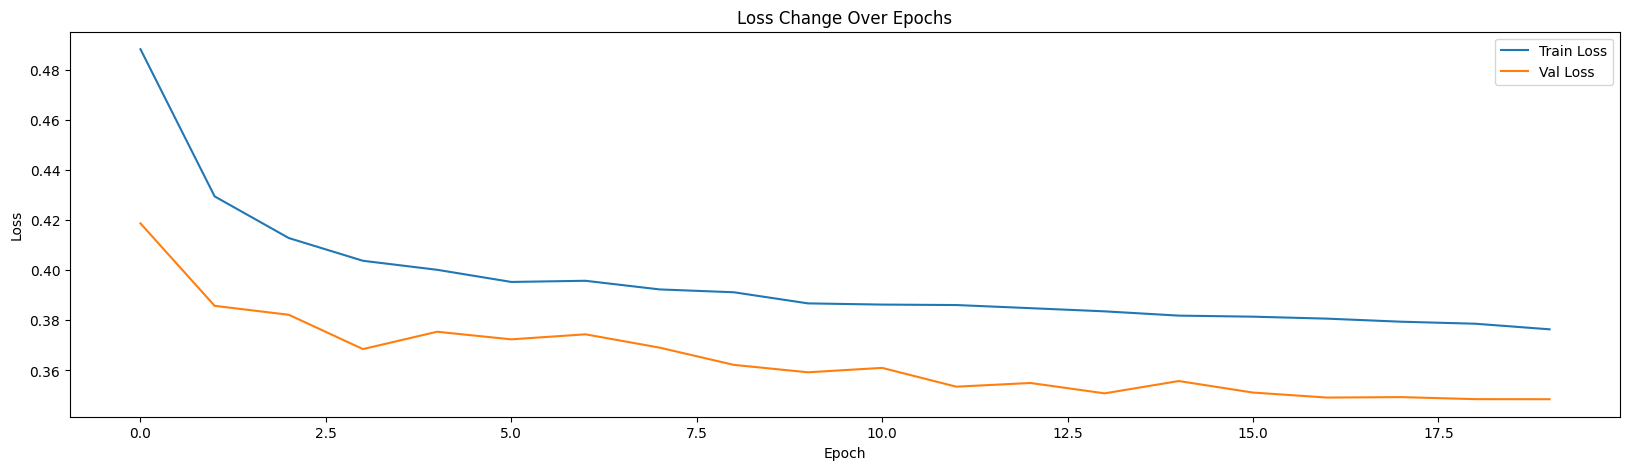

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(range(NUM_EPOCHS), train_loss_hist, label="Train Loss")
plt.plot(range(NUM_EPOCHS), val_loss_hist, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Change Over Epochs")
plt.legend()
plt.show()

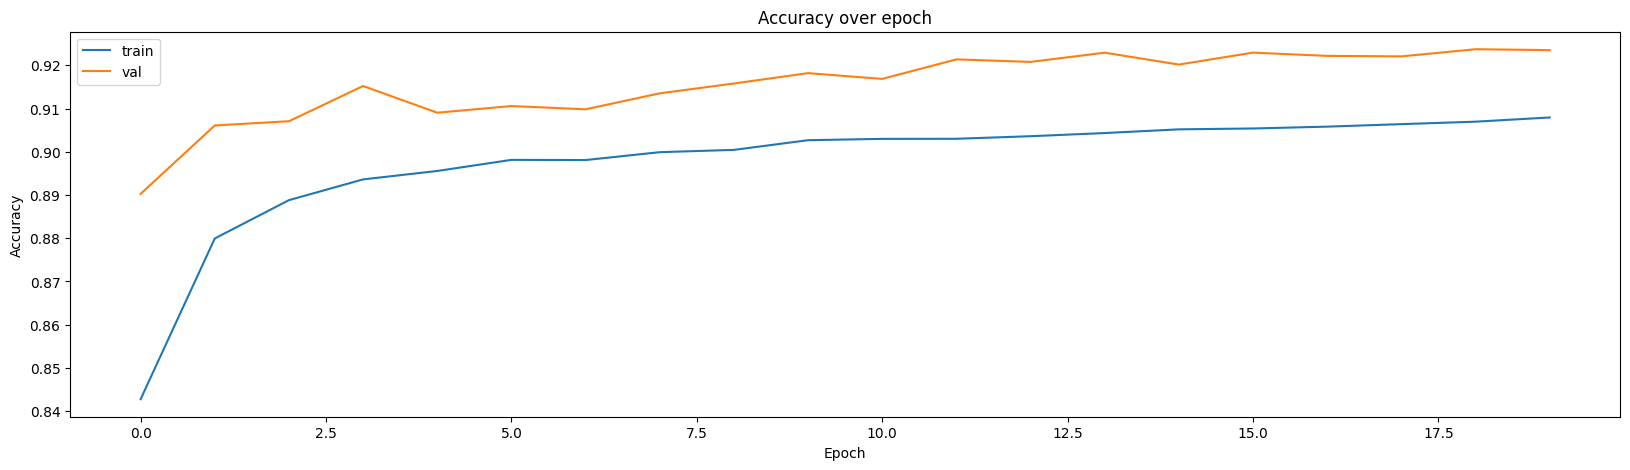

In [18]:
plt.figure(figsize=(20,5))
plt.plot(range(NUM_EPOCHS),train_auc_hist, label="train")
plt.plot(range(NUM_EPOCHS),val_auc_hist, label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

### Conclusion
The model shows consistent improvement throughout training. Both training and validation loss steadily decrease, while accuracy rises smoothly, indicating effective learning and minimal overfitting. Notably, validation accuracy exceeds training accuracy early on, likely due to dropout and other regularization effects during training. This suggests that the model generalizes well on the validation set.

One key learning from this project is that fitting convolutional neural networks (CNNs) is extremely slow without a GPU. Even with GPU support, small inefficiencies in the code, such as poor data loading or excessive image resolution can drastically increase training time. Hyperparameter tuning was especially sensitive: smaller models with higher learning rates and moderate dropout performed better, highlighting the importance of balancing capacity and regularization. Going forward, I would explore data augmentation, learning rate scheduling, and deeper architectures with residual connections. Additionally, implementing early stopping and batch normalization monitoring could further stabilize and improve performance. I would also use a lower dropout rate as I think this is what caused my validation to be more accurate than training.

In [19]:
# Load model to device and set to eval mode
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for i, (images, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
        images = images.to(device, non_blocking=True)

        outputs = model(images)                   # shape: (B, 1)
        probs = torch.sigmoid(outputs)            # convert logits to probabilities
        probs = probs.squeeze(1).cpu().numpy()    # shape: (B,) on CPU

        predictions.extend(probs)                 # add to final list


100%|██████████| 225/225 [02:07<00:00,  1.77it/s]


In [20]:
sub['label'] = predictions
sub.to_csv('submission.csv', index=False)
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      57458 non-null  object 
 1   label   57458 non-null  float32
dtypes: float32(1), object(1)
memory usage: 673.5+ KB
